<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Да, можно, используя эмбеддинги, которые представляют слова в виде векторов. Фильтры будут проходить через полные строки, отвечающие за слова, а вот высота уже может быть произвольная. Минус этого всего: мы теряем информацию о положении слова или словосочетания в тексте, а также рядом стоящие слова не обязательно связаны друг с другом.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

<Ответ>

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ>

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

<Ответ>


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

<Ответ>

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ>

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
!wget https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-05-02 20:39:10--  https://www.dropbox.com/s/3hj16b0fj6yw7cc/data.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.1|:443... connected.
HTTP request sent, awaiting response... 429 Too Many Requests
2017-05-02 20:39:10 ERROR 429: Too Many Requests.


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [2]:
!~/anaconda2/bin/pip install tqdm
!~/anaconda2/bin/pip install scikit-image
!~/anaconda2/bin/pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

    100% |████████████████████████████████| 11.6MB 64kB/s  eta 0:00:01
Requirement already up-to-date: six in /home/o_sopilniak/anaconda2/lib/python2.7/site-packages (from agentnet==0.10.4)
Requirement already up-to-date: lasagne in /home/o_sopilniak/anaconda2/lib/python2.7/site-packages (from agentnet==0.10.4)
Requirement already up-to-date: theano>=0.8.2 in /home/o_sopilniak/anaconda2/lib/python2.7/site-packages (from agentnet==0.10.4)
Requirement already up-to-date: numpy>=1.9 in /home/o_sopilniak/anaconda2/lib/python2.7/site-packages (from agentnet==0.10.4)
Requirement already up-to-date: scipy>=0.14 in /home/o_sopilniak/anaconda2/lib/python2.7/site-packages (from theano>=0.8.2->agentnet==0.10.4)
  Found existing installation: agentnet 0.10.4
    Uninstalling agentnet-0.10.4:
      Successfully uninstalled agentnet-0.10.4
  Running setup.py install for agentnet ... - \ done


### Data preprocessing

In [3]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 5.27 s, sys: 552 ms, total: 5.82 s
Wall time: 5.83 s


In [4]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [5]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [6]:
# Build a Vocabulary

from collections import Counter

############# TO CODE IT BY YOURSELF ##################

word_counts = {}
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        for word in captions[img_i][caption_i]:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

In [7]:
vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [9]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [10]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want 128
LSTM_UNITS = 200 #pls change me if u want

In [11]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: Tesla K80 (0000:00:04.0)


In [12]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [13]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [14]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features, 0.5)  # <Apply Dropout Layer to regularise your Net>
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)  # <Apply Dense to acive LSTM_UNITS size of representation>
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [15]:
GRAD_CLIP = 5.

############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,  # ????
                    mask_input=l_mask,
                    grad_clipping=GRAD_CLIP)

In [16]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


In [17]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
loss = T.mean(loss)  # <mean over non-PAD tokens>

In [18]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = lasagne.layers.get_all_params(predicted_probabilities, trainable=True)
updates = lasagne.updates.adam(loss, weights)

In [19]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], loss, updates=updates, allow_input_downcast=True)
val_step   = theano.function([image_vectors, sentences], loss, allow_input_downcast=True)

/home/o_sopilniak/anaconda2/lib/python2.7/site-packages/theano/tensor/basic.py:5130: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [20]:
captions = np.array(captions)

In [21]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [22]:
generate_batch(img_codes,captions, 3)

(array([[-0.12864572,  0.08390705, -1.9783088 , ...,  0.14256597,
         -1.60523117,  9.64361954],
        [-3.03830767, -4.13003016, -1.73232973, ..., -2.51823783,
         -1.62093461,  2.98153639],
        [-0.68050897, -1.27121079,  1.68345964, ...,  0.42922026,
         -0.70567274, -0.16030407]], dtype=float32),
 array([[ 8481,  8717,  9816,   326,  9902,  3083,  8717,  9138,   164,
         10058,  9529,  8134,    -1,    -1],
        [ 8481,  8717,  1373,  3980,  8717,  2598,   879, 10259,   326,
           423,  8134,    -1,    -1,    -1],
        [ 8481,  8717,   346,  4241,  4521,  3974,  6090,  2854,  3323,
          8025,  4859,  3323,  4556,  8134]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [23]:
batch_size = 64 #adjust me
n_epochs   = 50 #adjust me
n_batches_per_epoch = 100 #adjust me
n_validation_batches = 100 #how many batches are used for validation after each epoch

In [24]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  1%|          | 1/100 [00:00<00:12,  8.12it/s]


Epoch: 0, train loss: 4.48293097973, val loss: 3.33674103022


  1%|          | 1/100 [00:00<00:10,  9.17it/s]


Epoch: 1, train loss: 3.08850972772, val loss: 2.85651180625


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 2, train loss: 2.71124347329, val loss: 2.61424976945


  2%|▏         | 2/100 [00:00<00:09, 10.70it/s]


Epoch: 3, train loss: 2.4518849051, val loss: 2.39181867838


  1%|          | 1/100 [00:00<00:12,  7.75it/s]


Epoch: 4, train loss: 2.38763287067, val loss: 2.33859926581


  1%|          | 1/100 [00:00<00:13,  7.37it/s]


Epoch: 5, train loss: 2.21440243304, val loss: 2.19717724323


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 6, train loss: 2.18424075961, val loss: 2.24796162307


  1%|          | 1/100 [00:00<00:11,  8.85it/s]


Epoch: 7, train loss: 2.12744623423, val loss: 2.12665020227


  1%|          | 1/100 [00:00<00:11,  8.81it/s]


Epoch: 8, train loss: 2.07723505497, val loss: 2.02639609635


  1%|          | 1/100 [00:00<00:10,  9.12it/s]


Epoch: 9, train loss: 2.07363178492, val loss: 2.00358877182


  2%|▏         | 2/100 [00:00<00:08, 10.92it/s]


Epoch: 10, train loss: 2.09659847617, val loss: 2.03877023101


  2%|▏         | 2/100 [00:00<00:08, 11.27it/s]


Epoch: 11, train loss: 1.95914605379, val loss: 1.95357836843


  1%|          | 1/100 [00:00<00:11,  8.73it/s]


Epoch: 12, train loss: 1.92353256226, val loss: 1.90603794158


  1%|          | 1/100 [00:00<00:10,  9.12it/s]


Epoch: 13, train loss: 1.93516002536, val loss: 1.961315521


  2%|▏         | 2/100 [00:00<00:09, 10.82it/s]


Epoch: 14, train loss: 1.90598965228, val loss: 1.92563543141


  2%|▏         | 2/100 [00:00<00:09, 10.60it/s]


Epoch: 15, train loss: 1.8367396456, val loss: 1.86407142997


  1%|          | 1/100 [00:00<00:10,  9.23it/s]


Epoch: 16, train loss: 1.85567862809, val loss: 1.84526144028


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 17, train loss: 1.81617574692, val loss: 1.82001372457


  1%|          | 1/100 [00:00<00:09,  9.99it/s]


Epoch: 18, train loss: 1.8367350769, val loss: 1.84536493063


  1%|          | 1/100 [00:00<00:10,  9.10it/s]


Epoch: 19, train loss: 1.86893581629, val loss: 1.85394852757


  1%|          | 1/100 [00:00<00:16,  6.15it/s]


Epoch: 20, train loss: 1.7848744458, val loss: 1.82447825074


  1%|          | 1/100 [00:00<00:15,  6.19it/s]


Epoch: 21, train loss: 1.83704600215, val loss: 1.83204793632


  1%|          | 1/100 [00:00<00:11,  8.71it/s]


Epoch: 22, train loss: 1.79238421977, val loss: 1.76890867949


  1%|          | 1/100 [00:00<00:11,  8.30it/s]


Epoch: 23, train loss: 1.83084917068, val loss: 1.73991830289


  1%|          | 1/100 [00:00<00:10,  9.66it/s]


Epoch: 24, train loss: 1.70167022407, val loss: 1.79183514059


  1%|          | 1/100 [00:00<00:12,  8.04it/s]


Epoch: 25, train loss: 1.70940379381, val loss: 1.67555205762


  1%|          | 1/100 [00:00<00:10,  9.65it/s]


Epoch: 26, train loss: 1.75236335397, val loss: 1.74790982366


  2%|▏         | 2/100 [00:00<00:09, 10.40it/s]


Epoch: 27, train loss: 1.74374806643, val loss: 1.70251482606


  1%|          | 1/100 [00:00<00:10,  9.15it/s]


Epoch: 28, train loss: 1.7517004472, val loss: 1.74760743082


  2%|▏         | 2/100 [00:00<00:09, 10.48it/s]


Epoch: 29, train loss: 1.69218866348, val loss: 1.69532248557


  2%|▏         | 2/100 [00:00<00:09, 10.09it/s]


Epoch: 30, train loss: 1.70313904345, val loss: 1.71412743568


  1%|          | 1/100 [00:00<00:13,  7.41it/s]


Epoch: 31, train loss: 1.72693204761, val loss: 1.71613142371


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 32, train loss: 1.64555134535, val loss: 1.6787245816


  1%|          | 1/100 [00:00<00:10,  9.57it/s]


Epoch: 33, train loss: 1.69881048739, val loss: 1.67849919915


  1%|          | 1/100 [00:00<00:12,  8.10it/s]


Epoch: 34, train loss: 1.68585102677, val loss: 1.67974295676


  1%|          | 1/100 [00:00<00:18,  5.44it/s]


Epoch: 35, train loss: 1.69310609579, val loss: 1.66047523737


  1%|          | 1/100 [00:00<00:16,  6.16it/s]


Epoch: 36, train loss: 1.66140950739, val loss: 1.68323240936


  1%|          | 1/100 [00:00<00:14,  6.65it/s]


Epoch: 37, train loss: 1.68159866214, val loss: 1.61545803905


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 38, train loss: 1.60567699492, val loss: 1.64275907934


  1%|          | 1/100 [00:00<00:09,  9.97it/s]


Epoch: 39, train loss: 1.66602342188, val loss: 1.64948653102


  2%|▏         | 2/100 [00:00<00:09, 10.78it/s]


Epoch: 40, train loss: 1.67662107706, val loss: 1.6432172358


  1%|          | 1/100 [00:00<00:10,  9.43it/s]


Epoch: 41, train loss: 1.63507354617, val loss: 1.65912777781


  1%|          | 1/100 [00:00<00:11,  8.35it/s]


Epoch: 42, train loss: 1.65668590069, val loss: 1.64279602647


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 43, train loss: 1.59873924851, val loss: 1.63476067603


  1%|          | 1/100 [00:00<00:16,  6.01it/s]


Epoch: 44, train loss: 1.64312203705, val loss: 1.64466524005


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 45, train loss: 1.60453255713, val loss: 1.57668382883


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 46, train loss: 1.64408225119, val loss: 1.64996457696


  1%|          | 1/100 [00:00<00:11,  8.43it/s]


Epoch: 47, train loss: 1.63712042212, val loss: 1.61685120344


  1%|          | 1/100 [00:00<00:15,  6.20it/s]


Epoch: 48, train loss: 1.6326548785, val loss: 1.61771900892


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]



Epoch: 49, train loss: 1.57489730239, val loss: 1.56313232303
Finish :)


### apply trained model

In [25]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

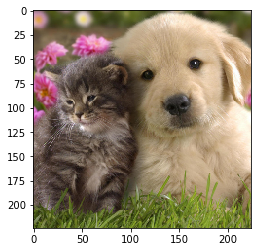

In [27]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [28]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=2,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [29]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

two boys are sitting on an office holding the camera
blue and black and yellow hair looking at the cat as a pimp plays table with #UNK# hands
soft #UNK# is an orange cat is laying down
a blue cat walks a video face by another the window where the stuffed dog lying on besides the surface
a baby that is laying on a green chair while wearing a hat is looking over to a being game
closeup of a black and white cat taking a hat
a cat pets her hair with a plastic icing
white cat posing is laying down on couch
brown baby eating a white blanket sitting in a chair as a cat peeking to its flyers resting by a cowboy trainer
there is a little boy sitting on a wave


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 